In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [44]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-6.3.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [66]:
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation,metrics
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LogisticRegressionCV

In [46]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import xgboost as xgb
pd.options.display.max_rows = 100

In [3]:
data = pd.read_csv("train.csv")
data.head()
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
data['Age'] = data['Age'].fillna(data['Age'].mean())
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
def status(feature):
    print('Processing',feature,': ok')

In [6]:
def get_combined_data():
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    # extracting and then removing the targets from the training data 
    targets = train.Survived
    train.drop('Survived',1,inplace=True)
    
    # merging train data and test data for future feature engineering
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop('index',inplace = True,axis=1)
    
    return combined

In [7]:
combined = get_combined_data()
combined.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
def get_titles():
    combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    # a map of more aggregated titles
    Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"
                      }
    # we map each title
    combined['Title'] = combined.Title.map(Title_Dictionary)

In [9]:
get_titles()

In [10]:
combined.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [11]:
grouped = combined.groupby(['Sex','Pclass','Title'])
grouped.median()

PassengerId   Age  SibSp  Parch      Fare
Sex    Pclass Title                                             
female 1      Miss           529.5  30.0    0.0    0.0   99.9625
              Mrs            853.5  45.0    1.0    0.0   78.1125
              Officer        797.0  49.0    0.0    0.0   25.9292
              Royalty        760.0  39.0    0.0    0.0   86.5000
       2      Miss           606.5  20.0    0.0    0.0   20.2500
              Mrs            533.0  30.0    1.0    0.0   26.0000
       3      Miss           603.5  18.0    0.0    0.0    8.0500
              Mrs            668.5  31.0    1.0    1.0   15.5000
male   1      Master         803.0   6.0    1.0    2.0  134.5000
              Mr             634.0  41.5    0.0    0.0   47.1000
              Officer        678.0  52.0    0.0    0.0   37.5500
              Royalty        600.0  40.0    0.0    0.0   27.7208
       2      Master         550.0   2.0    1.0    1.0   26.0000
              Mr             723.5  30.0    0.0    0.0   13.0000
              Officer        513.0  41.5    0.0    0.0   13.0000
       3      Master         789.0   6.0    3.0    1.0   22.3583
              Mr             640.5  26.0    0.0    0.0    7.8958

In [12]:
def process_age():
    def fillAges(row):
        if row['Sex']=='female' and row['Pclass'] == 1:
            if row['Title'] == 'Miss':
                return 30
            elif row['Title'] == 'Mrs':
                return 45
            elif row['Title'] == 'Officer':
                return 49
            elif row['Title'] == 'Royalty':
                return 39

        elif row['Sex']=='female' and row['Pclass'] == 2:
            if row['Title'] == 'Miss':
                return 20
            elif row['Title'] == 'Mrs':
                return 30

        elif row['Sex']=='female' and row['Pclass'] == 3:
            if row['Title'] == 'Miss':
                return 18
            elif row['Title'] == 'Mrs':
                return 31

        elif row['Sex']=='male' and row['Pclass'] == 1:
            if row['Title'] == 'Master':
                return 6
            elif row['Title'] == 'Mr':
                return 41.5
            elif row['Title'] == 'Officer':
                return 52
            elif row['Title'] == 'Royalty':
                return 40

        elif row['Sex']=='male' and row['Pclass'] == 2:
            if row['Title'] == 'Master':
                return 2
            elif row['Title'] == 'Mr':
                return 30
            elif row['Title'] == 'Officer':
                return 41.5

        elif row['Sex']=='male' and row['Pclass'] == 3:
            if row['Title'] == 'Master':
                return 6
            elif row['Title'] == 'Mr':
                return 26
    combined.Age = combined.apply(lambda r: fillAges(r) if np.isnan(r['Age']) else r['Age'],axis=1)
    status('age')

In [13]:
process_age()

Processing age : ok


In [14]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Title          1309 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 122.8+ KB


In [15]:
def process_names():
    global combined
    combined.drop('Name',axis=1,inplace=True)
    title_dummies = pd.get_dummies(combined['Title'],prefix='Title')
    # encoding in dummy variable
    combined = pd.concat([combined,title_dummies],axis=1)
    # removing the title variable
    combined.drop('Title',axis=1,inplace=True)
    status('names')

In [16]:
process_names()

Processing names : ok


In [17]:
combined.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,1,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,0.0,1.0,0.0,0.0,0.0
1,2,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0.0,0.0,0.0,1.0,0.0,0.0
2,3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,1.0,0.0,0.0,0.0,0.0
3,4,1,female,35.0,1,0,113803,53.1000,C123,S,0.0,0.0,0.0,1.0,0.0,0.0
4,5,3,male,35.0,0,0,373450,8.0500,NaN,S,0.0,0.0,1.0,0.0,0.0,0.0


In [18]:
def process_fares():
    combined.Fare.fillna(combined['Fare'].mean(),inplace= True)
    status('fares')

In [19]:
process_fares()

Processing fares : ok


In [20]:
def process_embarked():
    
    global combined
    # two missing embarked values - filling them with the most frequent one (S)
    combined.Embarked.fillna('S',inplace=True)
    
    # dummy encoding 
    embarked_dummies = pd.get_dummies(combined['Embarked'],prefix='Embarked')
    combined = pd.concat([combined,embarked_dummies],axis=1)
    combined.drop('Embarked',axis=1,inplace=True)
    
    status('embarked')

In [21]:
process_embarked()

Processing embarked : ok


In [22]:
def process_cabin():
    
    global combined
    
    # replacing missing cabins with U (for Uknown)
    combined.Cabin.fillna('U',inplace=True)
    
    # mapping each Cabin value with the cabin letter
    combined['Cabin'] = combined['Cabin'].map(lambda c : c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(combined['Cabin'],prefix='Cabin')
    
    combined = pd.concat([combined,cabin_dummies],axis=1)
    
    combined.drop('Cabin',axis=1,inplace=True)
    
    status('cabin')

In [23]:
process_cabin()

Processing cabin : ok


In [24]:
def process_sex():
    
    global combined
    # mapping string values to numerical one 
    combined['Sex'] = combined['Sex'].map({'male':1,'female':0})
    
    status('sex')

In [25]:
process_sex()

Processing sex : ok


In [26]:
def process_pclass():
    
    global combined
    # encoding into 3 categories:
    pclass_dummies = pd.get_dummies(combined['Pclass'],prefix="Pclass")
    
    # adding dummy variables
    combined = pd.concat([combined,pclass_dummies],axis=1)
    
    # removing "Pclass"
    
    combined.drop('Pclass',axis=1,inplace=True)
    
    status('pclass')

In [27]:
process_pclass()

Processing pclass : ok


In [28]:
def process_ticket():
    
    global combined
    
    # a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
    def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip() , ticket)
        ticket = list(filter(lambda t : not t.isdigit(), ticket))
        if len(ticket) > 0:
            return ticket[0]
        else: 
            return 'XXX'
    

    # Extracting dummy variables from tickets:

    combined['Ticket'] = combined['Ticket'].map(cleanTicket)
    tickets_dummies = pd.get_dummies(combined['Ticket'],prefix='Ticket')
    combined = pd.concat([combined, tickets_dummies],axis=1)
    combined.drop('Ticket',inplace=True,axis=1)

    status('ticket')

In [29]:
process_ticket()

Processing ticket : ok


In [30]:
def process_family():
    
    global combined
    # introducing a new feature : the size of families (including the passenger)
    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    
    # introducing other features based on the family size
    combined['Singleton'] = combined['FamilySize'].map(lambda s : 1 if s == 1 else 0)
    combined['SmallFamily'] = combined['FamilySize'].map(lambda s : 1 if 2<=s<=4 else 0)
    combined['LargeFamily'] = combined['FamilySize'].map(lambda s : 1 if 5<=s else 0)
    
    status('family')

In [31]:
process_family()
combined.head()

Processing family : ok


,PassengerId,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,1,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1,0
1,2,0,38.0,1,0,71.2833,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1,0
2,3,0,26.0,0,0,7.9250,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0
3,4,0,35.0,1,0,53.1000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,0,1,0
4,5,1,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0,0


In [32]:
def scale_all_features():
    features = list(combined.columns)
    features.remove('PassengerId')
    combined[features] = combined[features].apply(lambda x: x/x.max(), axis=0)
    print('Features scaled successfully !')

In [33]:
scale_all_features()

Features scaled successfully !


In [34]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score

C:\Users\Ambar Gupta\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Ambar Gupta\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [35]:
def compute_score(clf, X, y,scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5,scoring=scoring)
    return np.mean(xval)

In [36]:
def recover_train_test_target():
    train0 = pd.read_csv('train.csv')
    targets = train0.Survived
    train = combined.ix[0:890]
    test = combined.ix[891:]
    return train,test,targets

In [37]:
train,test,targets = recover_train_test_target()

In [38]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(train, targets)

In [39]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort(['importance'],ascending=False)

,feature,importance
0,PassengerId,0.128781
2,Age,0.121914
1,Sex,0.111873
5,Fare,0.110067
8,Title_Mr,0.107524
26,Pclass_3,0.037810
9,Title_Mrs,0.037353
7,Title_Miss,0.037183
23,Cabin_U,0.027665
64,FamilySize,0.020714


In [40]:
model = SelectFromModel(clf, prefit=True)
train_new = model.transform(train)
train_new.shape

(891, 16)

In [41]:
test_new = model.transform(test)
test_new.shape

(418, 16)

In [43]:
train.head()

,PassengerId,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,1.0,0.2750,0.125,0.0,0.014151,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818,0.0,1.0,0.0
1,2,0.0,0.4750,0.125,0.0,0.139136,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818,0.0,1.0,0.0
2,3,0.0,0.3250,0.000,0.0,0.015469,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.090909,1.0,0.0,0.0
3,4,0.0,0.4375,0.125,0.0,0.103644,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.181818,0.0,1.0,0.0
4,5,1.0,0.4375,0.000,0.0,0.015713,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.090909,1.0,0.0,0.0


In [132]:
forest = RandomForestClassifier(max_features='sqrt')

parameter_grid = {
                 'max_depth' : [4,5,6,7,8,10],
                 'n_estimators': [100,200,210,240,250],
                 'criterion': ['gini','entropy']
                 }

cross_validation = StratifiedKFold(targets, n_folds=10)

grid_search = GridSearchCV(forest,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(train_new, targets)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8361391694725028
Best parameters: {'n_estimators': 240, 'criterion': 'gini', 'max_depth': 4}


In [112]:
forest

NameError: name 'forest' is not defined

In [48]:
features = (train.columns).tolist()
features

['PassengerId',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Officer',
 'Title_Royalty',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Cabin_A',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_G',
 'Cabin_T',
 'Cabin_U',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Ticket_A',
 'Ticket_A4',
 'Ticket_A5',
 'Ticket_AQ3',
 'Ticket_AQ4',
 'Ticket_AS',
 'Ticket_C',
 'Ticket_CA',
 'Ticket_CASOTON',
 'Ticket_FC',
 'Ticket_FCC',
 'Ticket_Fa',
 'Ticket_LINE',
 'Ticket_LP',
 'Ticket_PC',
 'Ticket_PP',
 'Ticket_PPP',
 'Ticket_SC',
 'Ticket_SCA3',
 'Ticket_SCA4',
 'Ticket_SCAH',
 'Ticket_SCOW',
 'Ticket_SCPARIS',
 'Ticket_SCParis',
 'Ticket_SOC',
 'Ticket_SOP',
 'Ticket_SOPP',
 'Ticket_SOTONO2',
 'Ticket_SOTONOQ',
 'Ticket_SP',
 'Ticket_STONO',
 'Ticket_STONO2',
 'Ticket_STONOQ',
 'Ticket_SWPP',
 'Ticket_WC',
 'Ticket_WEP',
 'Ticket_XXX',
 'FamilySize',
 'Singleton',
 'SmallFamily',
 'LargeFamily']

In [54]:
target='Survived'

In [56]:
train['Survived'] = targets

In [57]:
train.shape

(891, 69)

In [63]:
features.remove('PassengerId')

['Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Officer',
 'Title_Royalty',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Cabin_A',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_G',
 'Cabin_T',
 'Cabin_U',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Ticket_A',
 'Ticket_A4',
 'Ticket_A5',
 'Ticket_AQ3',
 'Ticket_AQ4',
 'Ticket_AS',
 'Ticket_C',
 'Ticket_CA',
 'Ticket_CASOTON',
 'Ticket_FC',
 'Ticket_FCC',
 'Ticket_Fa',
 'Ticket_LINE',
 'Ticket_LP',
 'Ticket_PC',
 'Ticket_PP',
 'Ticket_PPP',
 'Ticket_SC',
 'Ticket_SCA3',
 'Ticket_SCA4',
 'Ticket_SCAH',
 'Ticket_SCOW',
 'Ticket_SCPARIS',
 'Ticket_SCParis',
 'Ticket_SOC',
 'Ticket_SOP',
 'Ticket_SOPP',
 'Ticket_SOTONO2',
 'Ticket_SOTONOQ',
 'Ticket_SP',
 'Ticket_STONO',
 'Ticket_STONO2',
 'Ticket_STONOQ',
 'Ticket_SWPP',
 'Ticket_WC',
 'Ticket_WEP',
 'Ticket_XXX',
 'FamilySize',
 'Singleton',
 'SmallFamily',
 'LargeFamily']

In [64]:
len(features)

67

In [61]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()


Model Report
Accuracy : 0.8945
AUC Score (Train): 0.941188


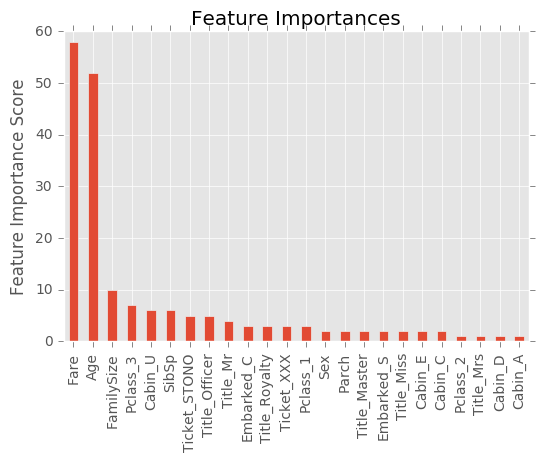

In [65]:
xgb1 = XGBClassifier(
learning_rate =0.3,   
 n_estimators=1000,
 max_depth=6,
 min_child_weight=1,
 gamma=0,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1,train,features)

In [69]:
param_test1 = {
    'max_depth':[3,5,7,9],
    'min_child_weight':[1,3,5]
}
gsearch1 = RandomizedSearchCV(xgb1, param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch1.fit(train[features],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.86109, std: 0.05049, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.86785, std: 0.04432, params: {'max_depth': 9, 'min_child_weight': 5},
  mean: 0.86779, std: 0.05659, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.87684, std: 0.05219, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.87512, std: 0.06036, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.86948, std: 0.04667, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.86593, std: 0.04498, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.86359, std: 0.04892, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.86858, std: 0.05706, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.87020, std: 0.04546, params: {'max_depth': 5, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1},
 0.876839345839346)

In [72]:
param_test2 = {
    'max_depth':[1,2,3,4,5,6,7,8,9,10],
    'min_child_weight':[1,2,3,4,5]
}
gsearch2 = GridSearchCV(estimator=xgb1, param_grid=param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch2.fit(train[features],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.85093, std: 0.03495, params: {'min_child_weight': 1, 'max_depth': 1},
  mean: 0.85093, std: 0.03495, params: {'max_depth': 1, 'min_child_weight': 2},
  mean: 0.85093, std: 0.03495, params: {'max_depth': 1, 'min_child_weight': 3},
  mean: 0.85093, std: 0.03495, params: {'max_depth': 1, 'min_child_weight': 4},
  mean: 0.85093, std: 0.03495, params: {'min_child_weight': 5, 'max_depth': 1},
  mean: 0.87051, std: 0.03353, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.87067, std: 0.03353, params: {'min_child_weight': 2, 'max_depth': 2},
  mean: 0.87067, std: 0.03353, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.87061, std: 0.03376, params: {'min_child_weight': 4, 'max_depth': 2},
  mean: 0.87061, std: 0.03376, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: 0.87684, std: 0.05219, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.87537, std: 0.05168, params: {'min_child_weight': 2, 'max_depth': 3},
  mean: 0.86948, std: 0.04667, params: {

In [74]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,9)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=1000, max_depth=3,
min_child_weight=1, gamma=0, subsample=1, colsample_bytree=1,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch3.fit(train[features],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.85280, std: 0.04985, params: {'gamma': 0.0},
  mean: 0.87015, std: 0.04961, params: {'gamma': 0.1},
  mean: 0.87221, std: 0.05381, params: {'gamma': 0.2},
  mean: 0.86898, std: 0.05112, params: {'gamma': 0.3},
  mean: 0.87275, std: 0.05502, params: {'gamma': 0.4},
  mean: 0.87540, std: 0.05303, params: {'gamma': 0.5},
  mean: 0.87644, std: 0.05160, params: {'gamma': 0.6},
  mean: 0.87398, std: 0.05200, params: {'gamma': 0.7},
  mean: 0.87541, std: 0.04783, params: {'gamma': 0.8}],
 {'gamma': 0.6},
 0.8764416857652151)

In [77]:
param_test4={
    'gamma':[0.51,0.52,0.53,0.54,0.55]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=1000, max_depth=3,
min_child_weight=1, gamma=0, subsample=1, colsample_bytree=1,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch4.fit(train[features],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.87599, std: 0.05090, params: {'gamma': 0.51},
  mean: 0.87802, std: 0.05187, params: {'gamma': 0.52},
  mean: 0.87734, std: 0.05196, params: {'gamma': 0.53},
  mean: 0.87821, std: 0.05235, params: {'gamma': 0.54},
  mean: 0.87771, std: 0.05330, params: {'gamma': 0.55}],
 {'gamma': 0.54},
 0.8782129134482076)


Model Report
Accuracy : 0.8765
AUC Score (Train): 0.938232


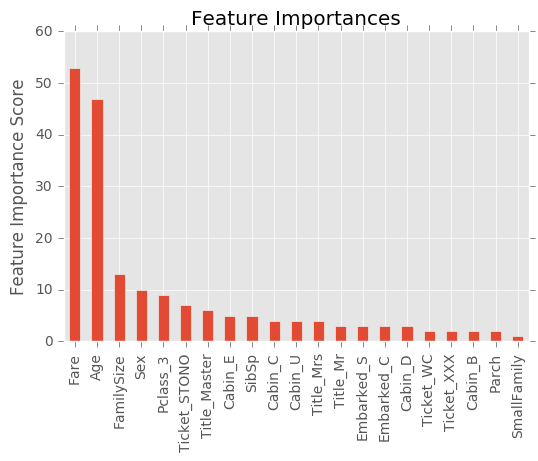

In [78]:
xgb2 = XGBClassifier(
learning_rate =0.3,   
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0.54,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2,train,features)

In [79]:
param_test5={
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=1000, max_depth=3,
min_child_weight=1, gamma=0.54, subsample=1, colsample_bytree=1,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch5.fit(train[features],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.85954, std: 0.05169, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.86323, std: 0.04370, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.86339, std: 0.05008, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.86345, std: 0.04887, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.85648, std: 0.04573, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.86251, std: 0.05034, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.86043, std: 0.04714, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.86663, std: 0.05037, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.86607, std: 0.04856, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.86135, std: 0.04758, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.86167, std: 0.04722, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.86591, std: 0.04747, params: {'colsample_bytree': 0.8, 'subsample'

In [80]:
param_test6={
    'subsample':[0.85,0.9,0.95],
    'colsample_bytree':[0.65,0.7,0.75]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=1000, max_depth=3,
min_child_weight=1, gamma=0.54, subsample=1, colsample_bytree=1,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch6.fit(train[features],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.86544, std: 0.04709, params: {'colsample_bytree': 0.65, 'subsample': 0.85},
  mean: 0.86364, std: 0.05057, params: {'colsample_bytree': 0.65, 'subsample': 0.9},
  mean: 0.86626, std: 0.04741, params: {'colsample_bytree': 0.65, 'subsample': 0.95},
  mean: 0.86862, std: 0.05031, params: {'colsample_bytree': 0.7, 'subsample': 0.85},
  mean: 0.86663, std: 0.05037, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.86929, std: 0.05130, params: {'colsample_bytree': 0.7, 'subsample': 0.95},
  mean: 0.86441, std: 0.04813, params: {'colsample_bytree': 0.75, 'subsample': 0.85},
  mean: 0.86386, std: 0.05085, params: {'colsample_bytree': 0.75, 'subsample': 0.9},
  mean: 0.86302, std: 0.04770, params: {'colsample_bytree': 0.75, 'subsample': 0.95}],
 {'colsample_bytree': 0.7, 'subsample': 0.95},
 0.8692885719944543)

In [82]:
param_test7={
    'subsample':[0.95,0.96,0.97,0.98,0.99,1.0]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=1000, max_depth=3,
min_child_weight=1, gamma=0.54, subsample=1, colsample_bytree=0.7,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch7.fit(train[features],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.86929, std: 0.05130, params: {'subsample': 0.95},
  mean: 0.86469, std: 0.04982, params: {'subsample': 0.96},
  mean: 0.86897, std: 0.04444, params: {'subsample': 0.97},
  mean: 0.86770, std: 0.04862, params: {'subsample': 0.98},
  mean: 0.86587, std: 0.04850, params: {'subsample': 0.99},
  mean: 0.87376, std: 0.05227, params: {'subsample': 1.0}],
 {'subsample': 1.0},
 0.8737598675833969)

In [86]:
param_test8={
    'reg_alpha':[1e-2,1e-3,1e-4]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=1000, max_depth=3,
min_child_weight=1, gamma=0.54, subsample=1, colsample_bytree=1,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch8.fit(train[features],train[target])
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: 0.87726, std: 0.05523, params: {'reg_alpha': 0.01},
  mean: 0.87634, std: 0.05208, params: {'reg_alpha': 0.001},
  mean: 0.87821, std: 0.05235, params: {'reg_alpha': 0.0001}],
 {'reg_alpha': 0.0001},
 0.8782129134482076)

In [95]:
param_test9={
    'n_estimators':[100,200,300,400,500,600,700,800,900,1000]
}
gsearch9 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=1000, max_depth=3,
min_child_weight=1, gamma=0.54, subsample=1, colsample_bytree=1,reg_alpha=0.0001,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
param_grid = param_test9, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch9.fit(train[features],train[target])
gsearch9.grid_scores_, gsearch9.best_params_, gsearch9.best_score_

([mean: 0.87821, std: 0.05235, params: {'n_estimators': 100},
  mean: 0.87821, std: 0.05235, params: {'n_estimators': 200},
  mean: 0.87821, std: 0.05235, params: {'n_estimators': 300},
  mean: 0.87821, std: 0.05235, params: {'n_estimators': 400},
  mean: 0.87821, std: 0.05235, params: {'n_estimators': 500},
  mean: 0.87821, std: 0.05235, params: {'n_estimators': 600},
  mean: 0.87821, std: 0.05235, params: {'n_estimators': 700},
  mean: 0.87821, std: 0.05235, params: {'n_estimators': 800},
  mean: 0.87821, std: 0.05235, params: {'n_estimators': 900},
  mean: 0.87821, std: 0.05235, params: {'n_estimators': 1000}],
 {'n_estimators': 100},
 0.8782129134482076)

In [96]:
param_test10={
    'learning_rate':[0.1,0.2,0.3,0.4,0.5]
}
gsearch10 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=100, max_depth=3,
min_child_weight=1, gamma=0.54, subsample=1, colsample_bytree=1,reg_alpha=0.0001,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
param_grid = param_test10, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch10.fit(train[features],train[target])
gsearch10.grid_scores_, gsearch10.best_params_, gsearch10.best_score_

([mean: 0.87568, std: 0.05179, params: {'learning_rate': 0.1},
  mean: 0.87247, std: 0.05056, params: {'learning_rate': 0.2},
  mean: 0.87821, std: 0.05235, params: {'learning_rate': 0.3},
  mean: 0.87661, std: 0.04909, params: {'learning_rate': 0.4},
  mean: 0.87393, std: 0.04844, params: {'learning_rate': 0.5}],
 {'learning_rate': 0.3},
 0.8782129134482076)

In [98]:
param_test11={
    'learning_rate':[0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3]
}
gsearch11 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.3, n_estimators=100, max_depth=3,
min_child_weight=1, gamma=0.54, subsample=1, colsample_bytree=1,reg_alpha=0.0001,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
param_grid = param_test11, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch11.fit(train[features],train[target])
gsearch11.grid_scores_, gsearch11.best_params_, gsearch11.best_score_

([mean: 0.87917, std: 0.05164, params: {'learning_rate': 0.21},
  mean: 0.87569, std: 0.05053, params: {'learning_rate': 0.22},
  mean: 0.87603, std: 0.05363, params: {'learning_rate': 0.23},
  mean: 0.87484, std: 0.05088, params: {'learning_rate': 0.24},
  mean: 0.87291, std: 0.05165, params: {'learning_rate': 0.25},
  mean: 0.87668, std: 0.05421, params: {'learning_rate': 0.26},
  mean: 0.87257, std: 0.04802, params: {'learning_rate': 0.27},
  mean: 0.87335, std: 0.05182, params: {'learning_rate': 0.28},
  mean: 0.87045, std: 0.05307, params: {'learning_rate': 0.29},
  mean: 0.87821, std: 0.05235, params: {'learning_rate': 0.3}],
 {'learning_rate': 0.21},
 0.8791748861160628)


Model Report
Accuracy : 0.8754
AUC Score (Train): 0.933337


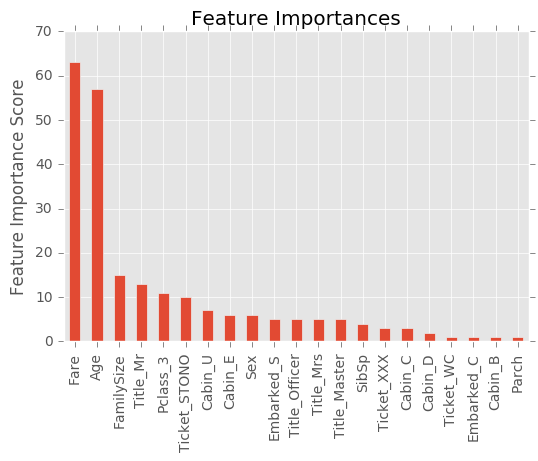

In [99]:
xgb3 = XGBClassifier(
learning_rate =0.21,   
 n_estimators=240,
 max_depth=4,
 min_child_weight=1,
 gamma=0.54,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3,train,features)

In [102]:
len(test.columns)

68

In [109]:
output = xgb3.predict(test[features])

In [110]:
print(type(output[0]))

<class 'numpy.int64'>


In [111]:
df_output = pd.DataFrame()
df_output['PassengerId'] = test['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('Xgboost1.csv',index=False)